<a href="https://colab.research.google.com/github/ThanhHung2112/DO_AN_1/blob/main/DeepFace_Recognititon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install retina-face

In [ ]:
! pip install deepface

In [ ]:
! pip install arcface

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
from google.colab.patches import cv2_imshow
from retinaface import RetinaFace
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from numpy import mean
from deepface import DeepFace
import pandas as pd

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename
  

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
'''
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
''' 

"\ntry:\n  filename = take_photo('photo.jpg')\n  print('Saved to {}'.format(filename))\n  \n  # Show the image which was just taken.\n  display(Image(filename))\nexcept Exception as err:\n  # Errors will be thrown if the user does not have a webcam or if they do not\n  # grant the page permission to access it.\n  print(str(err))\n"

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    #print('bbox1 :',bbox_array)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    #print('bbox2 :',bbox_array)
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    #print('bbox:',bbox_array)
    bbox = bbox_bytes


<IPython.core.display.Javascript object>

----
# Face Detectron

In [ ]:
img_path = '/content/drive/MyDrive/DO_AN_1/Photo/img6.png'
img2_path = '/content/drive/MyDrive/DO_AN_1/database/Tun_Phg.jpg'
img = cv2.imread(img_path)
img2 = cv2.imread(img2_path)

#cv2_imshow(img)
#/content/upimg1.png

In [ ]:
obj = RetinaFace.detect_faces(img_path)

retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:01<00:00, 99.1MB/s]


In [ ]:
len(obj.keys())

15

{'score': 0.9996180534362793, 'facial_area': [1565, 583, 1725, 782], 'landmarks': {'right_eye': [1589.67, 653.3119], 'left_eye': [1660.5182, 659.5669], 'nose': [1606.8774, 698.4947], 'mouth_right': [1591.5968, 722.8898], 'mouth_left': [1656.6387, 727.192]}}
{'score': 0.999516487121582, 'facial_area': [1166, 536, 1265, 658], 'landmarks': {'right_eye': [1182.117, 583.32715], 'left_eye': [1225.5299, 577.1715], 'nose': [1200.0247, 607.7682], 'mouth_right': [1192.2694, 628.6399], 'mouth_left': [1227.8219, 623.3688]}}
{'score': 0.9995018243789673, 'facial_area': [626, 481, 689, 563], 'landmarks': {'right_eye': [649.54987, 511.48523], 'left_eye': [678.5605, 514.79736], 'nose': [665.2389, 531.0067], 'mouth_right': [647.2038, 540.4167], 'mouth_left': [673.39026, 543.1947]}}
{'score': 0.9993999004364014, 'facial_area': [139, 530, 292, 723], 'landmarks': {'right_eye': [207.79369, 602.6827], 'left_eye': [271.671, 608.674], 'nose': [251.86224, 642.12036], 'mouth_right': [211.44418, 676.05524], 'mou

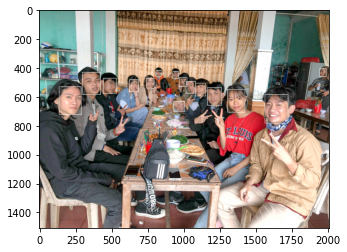

In [ ]:
for key in obj.keys():
  identity = obj[key]
  print(identity)

  facial_area = identity['facial_area']
  cv2.rectangle(img, (facial_area[0],facial_area[1]),(facial_area[2],facial_area[3]), (255,255,255), 2) # BGR

plt.imshow(img[:,:,::-1])

In [ ]:
def detect_faces_function(img):

  #cv2_imshow(img)
  obj = RetinaFace.detect_faces(img)
 
  print('='*100,'\n'
      'found', len(obj.keys()), 'face in picture','\n',
       '='*100)
  i = 1
  for key in obj.keys():
  
    identity = obj[key]

    r_eye = identity['landmarks']['right_eye']
    l_eye = identity['landmarks']['left_eye']
    nose = identity['landmarks']['nose']
    mouth_left = identity['landmarks']['mouth_left']
    mouth_right = identity['landmarks']['mouth_right']

    # detect and draw line on eye, nose, mouth 
    
    cv2.line(img, (int(r_eye[0]),int(r_eye[1])), (int(l_eye[0]),int(l_eye[1])), (0,255,0), 2)
    cv2.line(img, (int(r_eye[0]),int(r_eye[1])), (int(nose[0]),int(nose[1])), (0,0,255), 2)
    cv2.line(img, (int(l_eye[0]),int(l_eye[1])), (int(nose[0]),int(nose[1])), (0,0,255), 2)
    x = (int(mouth_left[0]) + int(mouth_right[0]))/2
    y = (int(mouth_left[1]) + int(mouth_right[1]))/2
    
    cv2.line(img, (int(mouth_left[0]),int(mouth_left[1])), (int(mouth_right[0]),int(mouth_right[1])), (0,0,255), 2)
    cv2.line(img, (int(nose[0]),int(nose[1])), (int(x),int(y)), (255,0,0), 2)

    # rectangle faces
   
    facial_area = identity['facial_area']
    cv2.rectangle(img, (facial_area[0],facial_area[1]),(facial_area[2],facial_area[3]), (255,255,255), 2) # BGR

    text_size = (facial_area[2] - facial_area[0])/140
    # write up face
    #print((facial_area[2] - facial_area[0],facial_area[3] - facial_area[1]))
    cv2.putText(img, 'Person.{}'.format(i) ,(facial_area[0],facial_area[1]- 15)
    ,fontFace = cv2.FONT_HERSHEY_COMPLEX, fontScale = text_size, color = (0,0,255))
    i += 1
    #print(identity)
    #for key2 in identity:
    # print(identity[key2])
    #tuple(map(mean, zip(*x)))
    #break

    #print(identity)

  plt.figure(figsize= (15,15))
  plt.imshow(img[:,:,::-1])

  plt.show()
  return

found 15 face in picture 


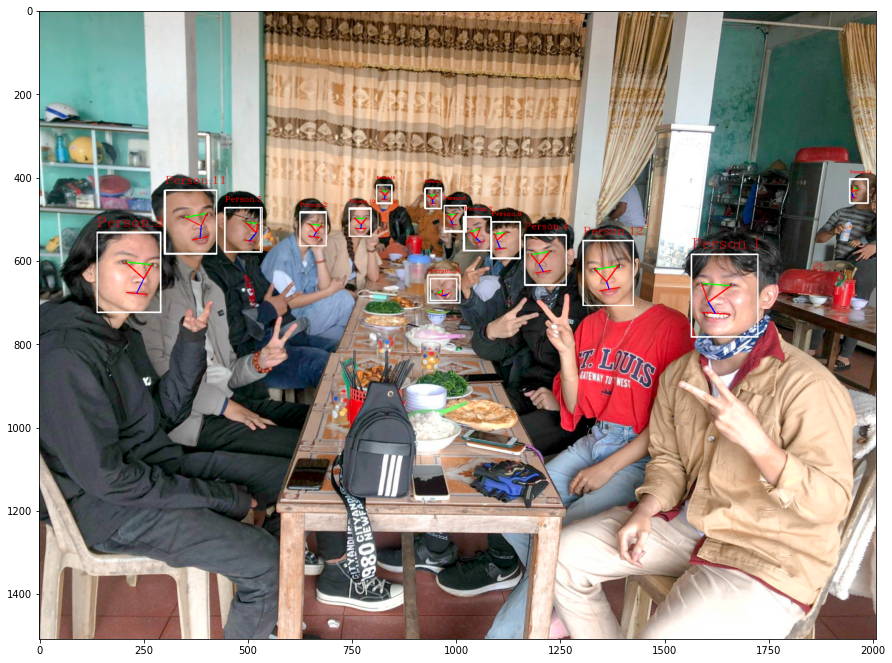

In [ ]:
detect_faces_function(img)

found 1 face in picture 


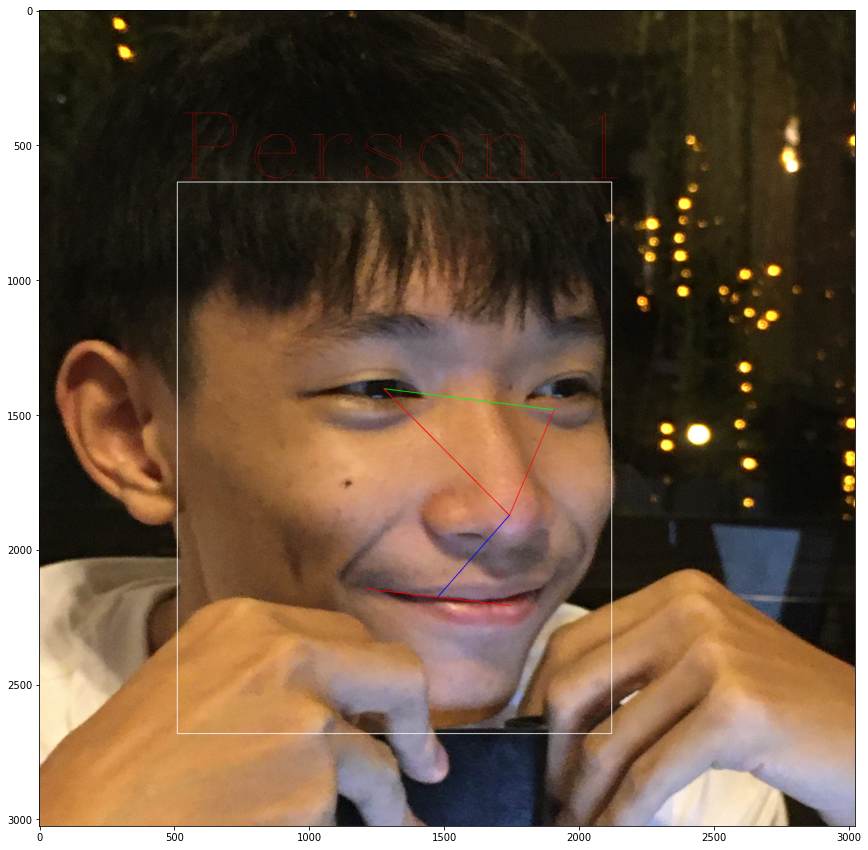

In [ ]:
detect_faces_function(img2)

----
# Face Recognition


In [ ]:
path = '/content/drive/MyDrive/DO_AN_1/Photo/'
img1_path = path + 'Train_img1.jpg'
img2_path = path + 'Train_img2.jpg'

img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

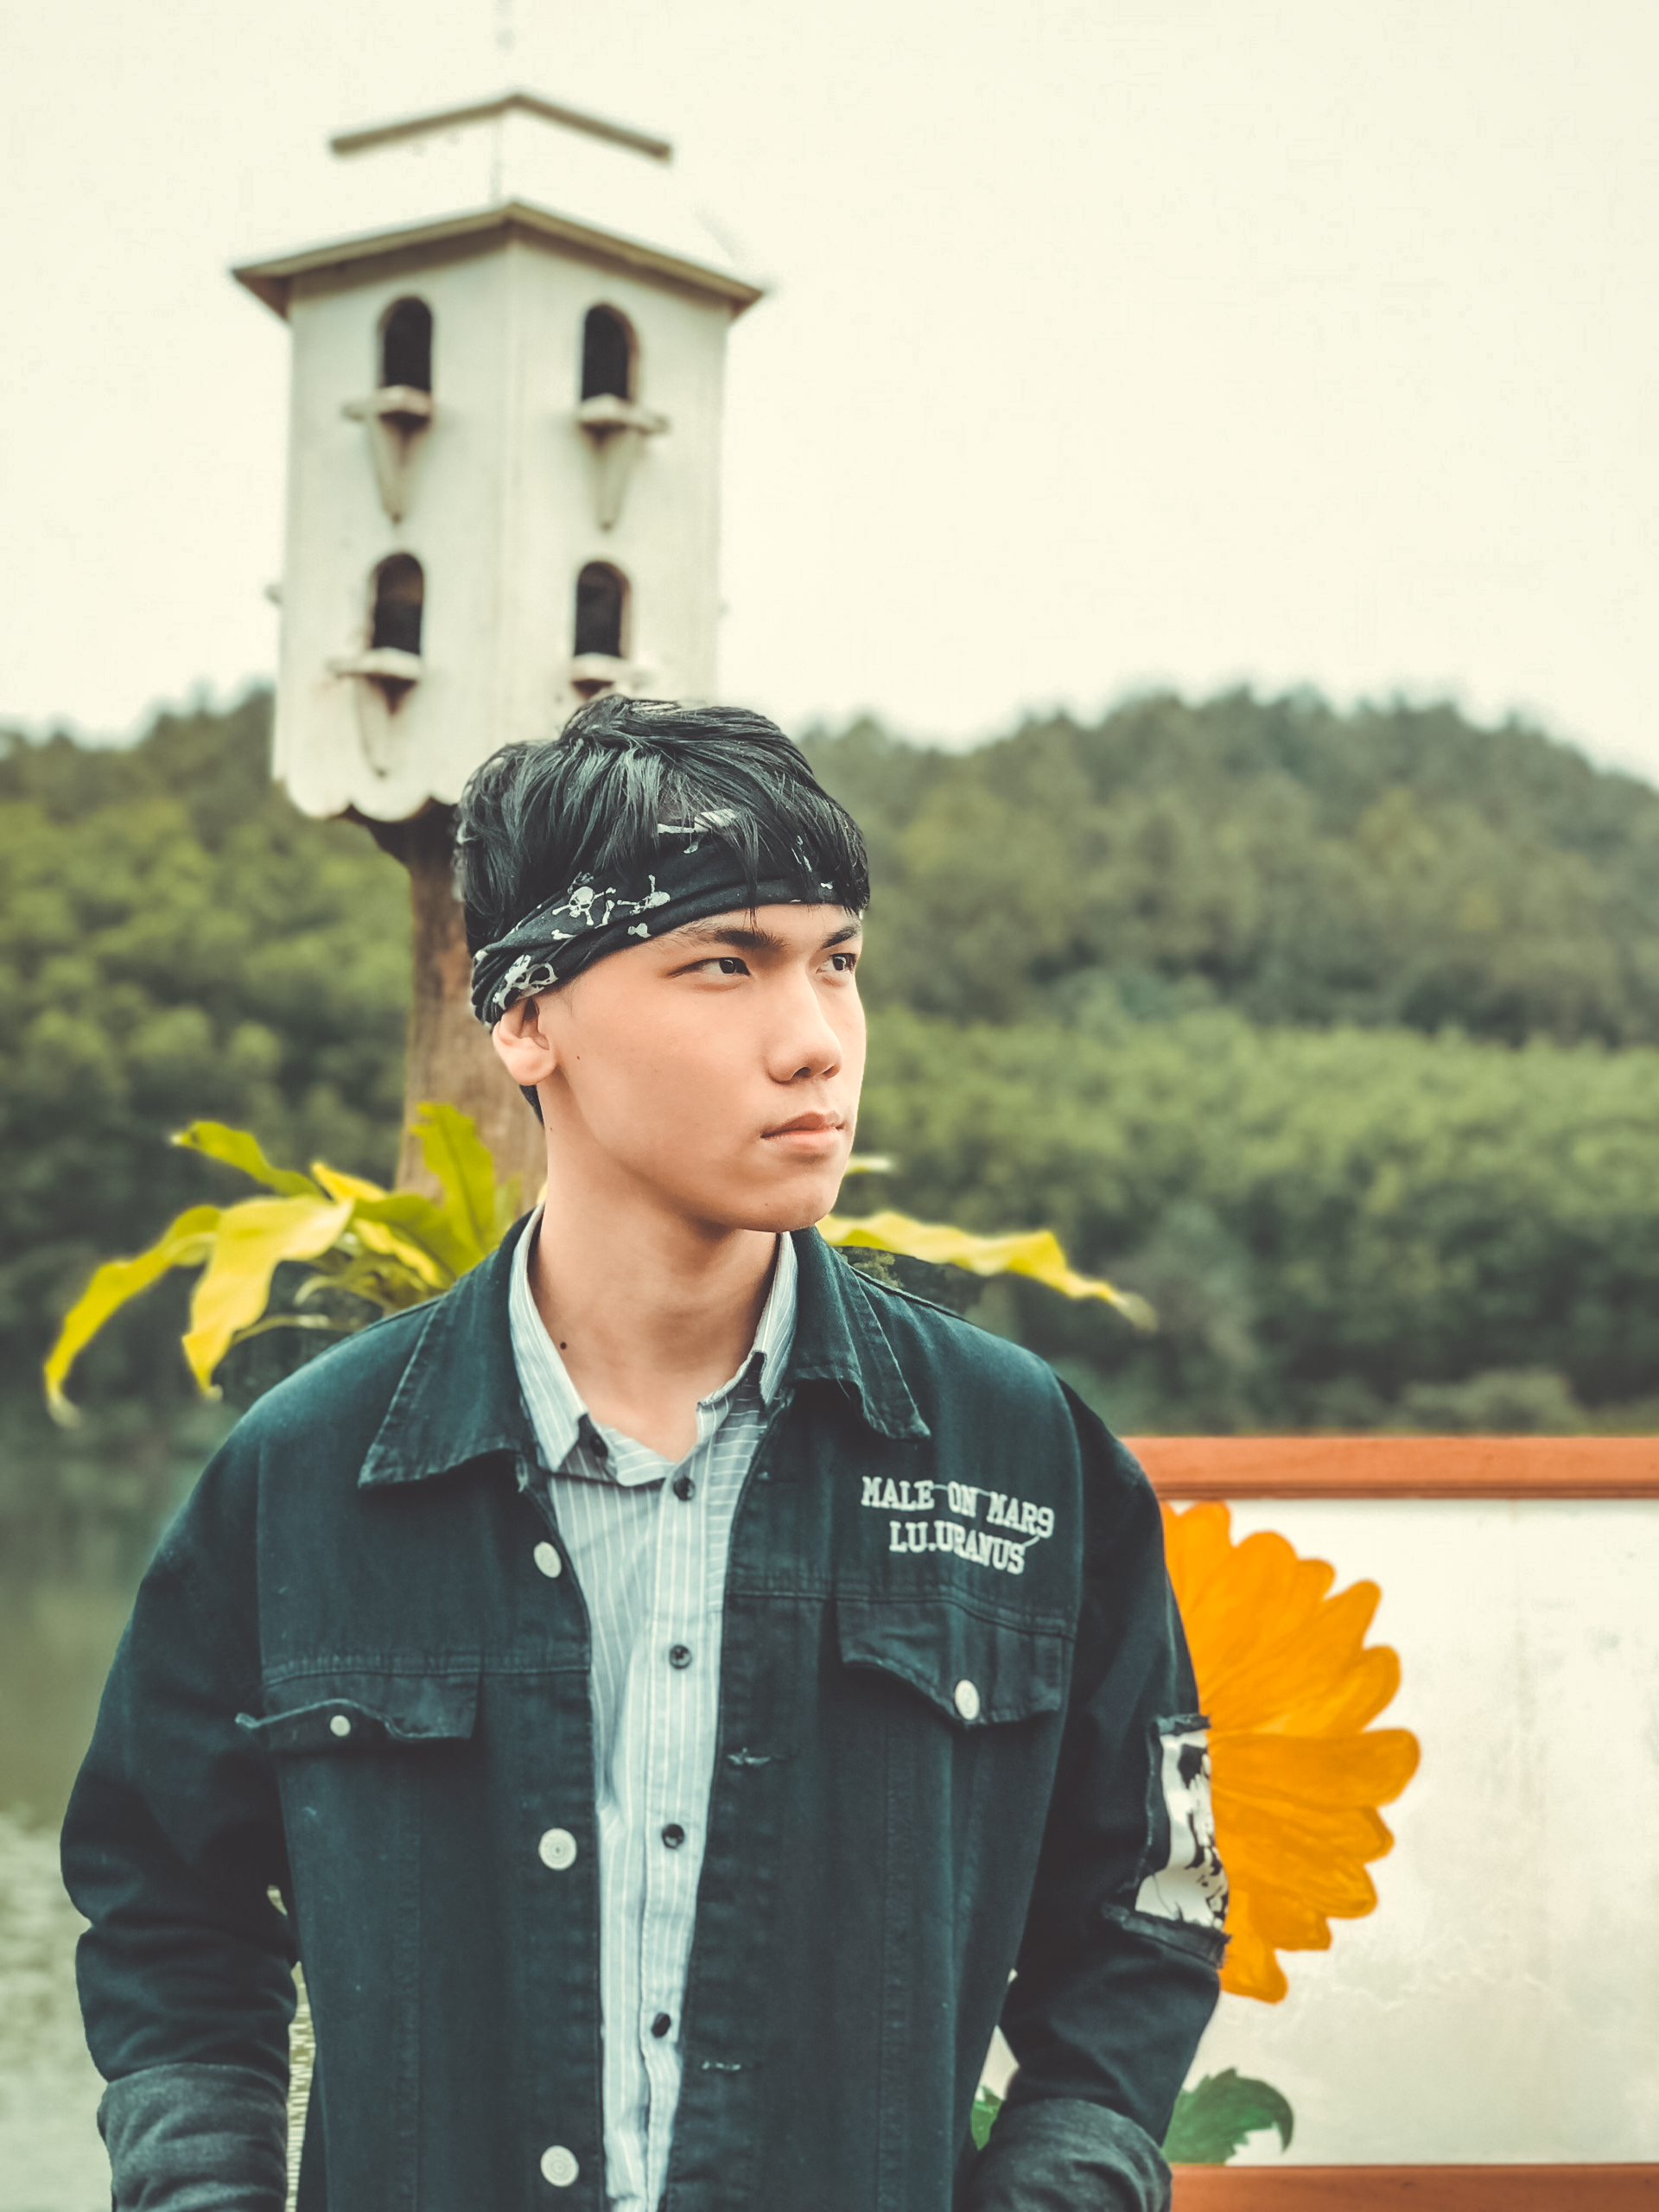

In [ ]:
cv2_imshow(img1)

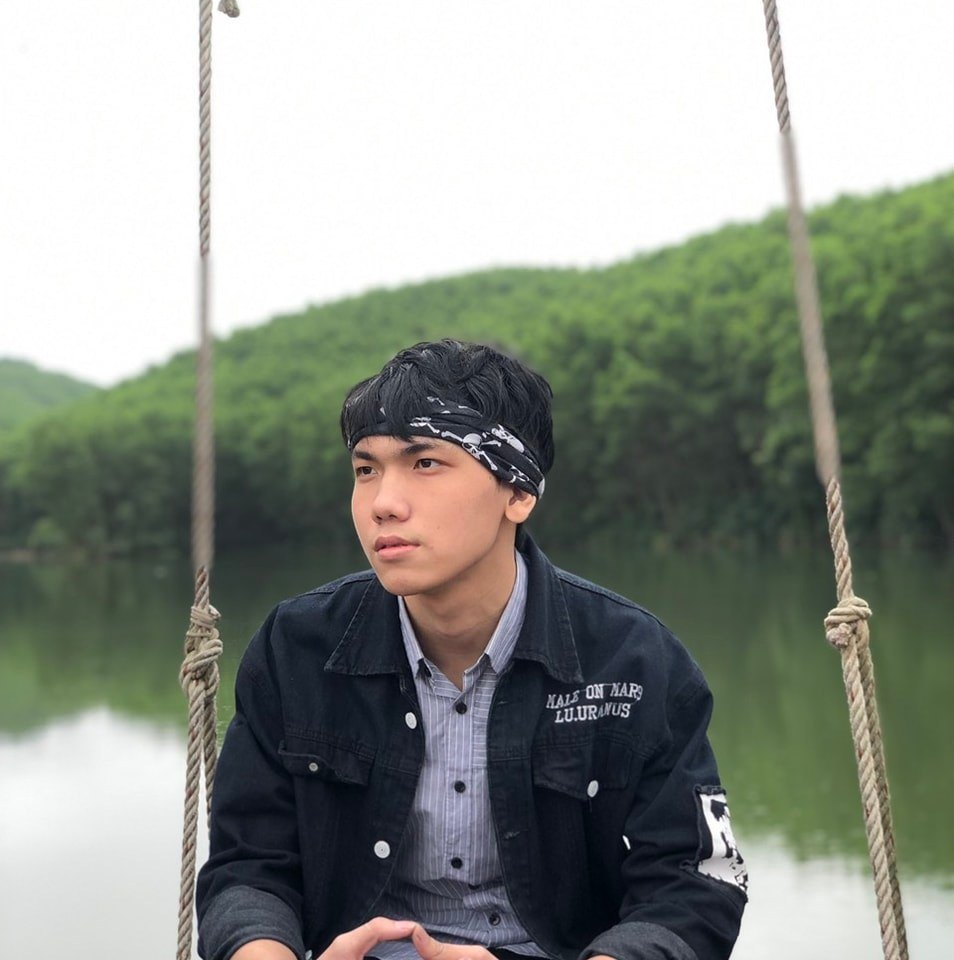

In [ ]:
cv2_imshow(img2)

In [ ]:
re_obj = DeepFace.verify(img1_path = img1_path, img2_path = img2_path, model_name = 'Facenet', detector_backend = 'retinaface' ) 

# model VGG-Face - Facenet - OpenFace - DeepID - Dlib - ArcFace - Ensemble 
# detector_backend opencv - mtcnn - retinaface

facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:00<00:00, 93.8MB/s]


In [ ]:
re_obj

{'detector_backend': 'retinaface',
 'distance': 0.13981357820157203,
 'model': 'Facenet',
 'similarity_metric': 'cosine',
 'threshold': 0.4,
 'verified': True}

In [ ]:
img1 = DeepFace.detectFace(img, detector_backend= 'dlib')
#img2 = DeepFace.detectFace(path + 'img4.png', detector_backend= 'retinaface')

Downloading...
From: http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
To: /root/.deepface/weights/shape_predictor_5_face_landmarks.dat.bz2


shape_predictor_5_face_landmarks.dat.bz2 is going to be downloaded


100%|██████████| 5.71M/5.71M [00:00<00:00, 16.5MB/s]


In [ ]:
df = DeepFace.find(img_path = img, db_path= path, detector_backend= 'mtcnn')

Representations stored in  /content/drive/MyDrive/DO_AN_1/database/ / representations_vgg_face.pkl  file. Please delete this file when you add new identities in your database.
find function lasts  16.445547580718994  seconds


In [ ]:
df

identity  VGG-Face_cosine
0  /content/drive/MyDrive/DO_AN_1/database//Train...         0.261091
1  /content/drive/MyDrive/DO_AN_1/database//Thanh...         0.265861
2  /content/drive/MyDrive/DO_AN_1/database//Train...         0.313146
3  /content/drive/MyDrive/DO_AN_1/database//Phc_N...         0.319111
4  /content/drive/MyDrive/DO_AN_1/database//Phc_c...         0.384550

In [ ]:
obj = DeepFace.analyze(img_path = img1_path, detector_backend= 'retinaface')

100%|██████████| 537M/537M [00:39<00:00, 13.7MB/s]
Action: race: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


In [ ]:
obj

{'age': 24,
 'dominant_emotion': 'fear',
 'dominant_race': 'asian',
 'emotion': {'angry': 1.4071726055053002,
  'disgust': 1.657141576691516e-15,
  'fear': 97.89863203747655,
  'happy': 1.7762079733420243e-13,
  'neutral': 0.5927096827578167,
  'sad': 0.10148489427758983,
  'surprise': 3.969316371368437e-06},
 'gender': 'Man',
 'race': {'asian': 99.98893737792969,
  'black': 1.5750420967464152e-07,
  'indian': 8.142511092046334e-05,
  'latino hispanic': 0.010830471728695557,
  'middle eastern': 4.471224224200654e-08,
  'white': 0.00014788259932174697},
 'region': {'h': 445, 'w': 349, 'x': 652, 'y': 975}}

In [ ]:
for key in obj.keys() - ['emotion','region', 'race']:
  print(obj[key])

Man
asian
fear
24


In [ ]:
obj['region']   

{'h': 445, 'w': 349, 'x': 652, 'y': 975}

In [ ]:
DeepFace.stream('/content/drive/MyDrive/DO_AN_1', detector_backend='mtcnn', model_name = 'ArcFace')

In [ ]:
'''
import cv2
from deepface import DeepFace

cam = cv2.VideoCapture(0)

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:

    ret, frame = cam.read()
    print(ret)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)

    for(x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    font = cv2.FONT_HERSHEY_SIMPLEX

    emotRes = DeepFace.analyze(frame, actions = ['emotion'])
    cv2.putText(frame, emotRes['emotion'], (50, 50), font, 1, (0, 0, 255), 2, cv2.LINE_4)

    cv2.putText(frame, "FPS: {}".format(cam.get(cv2.CAP_PROP_FPS)), (10,30), font, 1, (0, 255, 255), 2, cv2.LINE_4) 
    cv2.putText(frame, 'Press q to quit', (200,450), font, 1, (0, 255, 255), 2, cv2.LINE_4)
    cv2.imshow("ERS Visual V1.0 - Emotion Recognition System", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.release()
cv2.destroyAllWindows()
quit()
'''

In [ ]:
embedding = DeepFace.represent(img_path = img2_path
                               , detector_backend= 'retinaface',
                               model_name = 'ArcFace')

In [ ]:
embedding

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
Guess_face_adj = []
path = '/content/drive/MyDrive/DO_AN_1/database/'
while True:
  js_reply = video_frame(label_html, bbox)

  bbox_array = np.zeros([480,640,4], dtype=np.uint8)

  if not js_reply:
        break
  img = js_to_image(js_reply["img"])  
    
  obj = RetinaFace.detect_faces(img)
  
  if len(obj) == 0:
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
  else: 
    for key in obj.keys():
      identity = obj[key]
      #print(identity)
      r_eye = identity['landmarks']['right_eye']
      l_eye = identity['landmarks']['left_eye']
      nose = identity['landmarks']['nose']
      mouth_left = identity['landmarks']['mouth_left']
      mouth_right = identity['landmarks']['mouth_right']

      # detect and draw line on eye, nose, mouth 
      cv2.line(bbox_array, (int(r_eye[0]),int(r_eye[1])), (int(l_eye[0]),int(l_eye[1])), (0,0,255), 2)
      cv2.line(bbox_array, (int(r_eye[0]),int(r_eye[1])), (int(nose[0]),int(nose[1])), (0,0,255), 2)
      cv2.line(bbox_array, (int(l_eye[0]),int(l_eye[1])), (int(nose[0]),int(nose[1])), (0,0,255), 2)
      x = (int(mouth_left[0]) + int(mouth_right[0]))/2
      y = (int(mouth_left[1]) + int(mouth_right[1]))/2
      
      cv2.line(bbox_array, (int(mouth_left[0]),int(mouth_left[1])), (int(mouth_right[0]),int(mouth_right[1])), (0,0,255), 2)
      cv2.line(bbox_array, (int(nose[0]),int(nose[1])), (int(x),int(y)), (255,0,0), 2)

      facial_area = identity['facial_area']
      cv2.rectangle(bbox_array, (facial_area[2],facial_area[3]),(facial_area[0],facial_area[1]), (255,255,255), 2)
          
        # face recognition
        # crop img
      person_name = 'Person'
      #print('img[',facial_area[1],':',facial_area[3],',',facial_area[0],':',facial_area[2],']')
      df = DeepFace.find(img_path = img[facial_area[1]:facial_area[3],facial_area[0]:facial_area[2]]
                        , db_path =  path, detector_backend= 'mtcnn')
      person_name = str(df['identity'][0].replace(path,'')).replace('.jpg','')

      face_adj = DeepFace.analyze(img, detector_backend='retinaface')
      x = []
      for key in face_adj.keys() - ['emotion','region','race']:
        x.append(face_adj[key])  
      
      if x != Guess_face_adj: 
        Guess_face_adj = x
        print(Guess_face_adj)

      cv2.putText(bbox_array, person_name,(facial_area[0],facial_area[1] - 12),
                      fontFace = cv2.FONT_HERSHEY_COMPLEX, fontScale = 0.8, color = (250,225,100))
  bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

  bbox_bytes = bbox_to_bytes(bbox_array)
      # update bbox so next frame gets new overlay
      #print('bbox:',bbox_array)      
  bbox = bbox_bytes # [  45 : 384 , 219: 466 ]

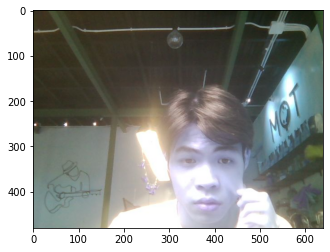

In [ ]:
plt.imshow(img)
# [292, 248, 463, 476]

In [ ]:
'''
    print('wait for minius')
    #person = DeepFace.find(img_path = img2_path, db_path= path, detector_backend= 'mtcnn', model_name='Ensemble')
    face_adj = DeepFace.analyze(img, detector_backend='retinaface')
    x = []
    for key in face_adj.keys() - ['emotion','region','race']:
      x.append(face_adj[key])  
      
    if x != Guess_face_adj: 
      Guess_face_adj = x
      print(Guess_face_adj)
'''

In [ ]:
!pip install ipython-autotime
%load_ext autotime

**What does ArcFace do?**

**ArcFace** is a machine learning model that takes **two face images as input** and **outputs the distance between them** to see how likely they are to be the same person. It can be used for face recognition and face search

In [ ]:
from arcface import ArcFace
face_rec = ArcFace.ArcFace()

emb1 = face_rec.calc_emb('/content/drive/MyDrive/DO_AN_1/Photo/Train_img2.jpg')
emb2 = face_rec.calc_emb('/content/drive/MyDrive/DO_AN_1/Photo/img7.png')

In [ ]:
if face_rec.get_distance_embeddings(emb1, emb2) < 0.5 :
  print('The Same',face_rec.get_distance_embeddings(emb1, emb2))
  

In [ ]:
4emb2 = face_rec.calc_emb('/content/drive/MyDrive/DO_AN_1/Photo/Train_img2.jpg')
list_img = []
for i in range(6):
  
  print(i)
  img_path =  '/content/drive/MyDrive/DO_AN_1/database/Train_img{}.jpg'.format(i+1)

  #img = DeepFace.detectFace(img_path, detector_backend= 'retinaface')
  #plt.imshow(img)
  emb1 = face_rec.calc_emb(img_path)

  #if face_rec.get_distance_embeddings(emb1, emb2) > 0.5:
  print('img{}.jpg'.format(i+1),face_rec.get_distance_embeddings(emb1, emb2))
  list_img.append(face_rec.get_distance_embeddings(emb1, emb2))

place = (list_img.index(min(list_img)) + 1)

img_path = '/content/drive/MyDrive/DO_AN_1/database/' + 'Train_img{}.jpg'.format(place)
img = cv2.imread(img_path)
plt.imshow(img[:,:,::-1])

In [ ]:
img_path = '/content/drive/MyDrive/DO_AN_1/Photo/Train_img3.jpg'
# img = DeepFace.detectFace(img_path, detector_backend= 'retinaface')
#plt.imshow(img)

In [ ]:
DeepFace.verify(img1_path = img_path, img2_path = '/content/drive/MyDrive/DO_AN_1/database/Train_img4.jpg',
                detector_backend='retinaface')

In [ ]:
path = '/content/drive/MyDrive/DO_AN_1/database/'
plt.imshow(img)
df = DeepFace.find(img_path = img, db_path = '/content/drive/MyDrive/DO_AN_1/database/',
                detector_backend='retinaface', model_name ='Ensemble')
str(df['identity'][0]).replace(path,'')

In [ ]:
plt.imshow(img[:,:,::-1])


In [ ]:
img_path = '/content/drive/MyDrive/DO_AN_1/Photo/Train_img1.jpg'
img = cv2.imread(img_path)

#plt.imshow(img[:,:,::-1])
cropped_image = img[975:1420,652:1001]
# [652, 975, 1001, 1420]
plt.imshow(cropped_image[:,:,::-1])